<a href="https://colab.research.google.com/github/aproca/XAI_course_labs/blob/main/Lab1_LinearModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Interpretable Linear Models (Regression & Classification)

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# Part 1: Regression (Bike rentals)

We predict the daily number of bike rentals (`cnt`) from weather and calendar features.
The goal is to compare predictive performance and interpretability of linear models.

In [2]:
# Download bike dataset
!wget http://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
!unzip bike+sharing+dataset.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Load and preprocess data

This section:
1. Downloads and loads the dataset.
2. Rescales some features back to natural units (°C, %, km/h) so coefficients are interpretable.
3. Creates train/test splits in temporal order (no shuffling).

In [3]:
df = pd.read_csv('day.csv')

In [4]:
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [5]:
df['temp'] = df['temp'] * 47 - 8
df['atemp'] = df['atemp'] * 66 - 16
df['windspeed'] = df['windspeed'] * 67
df['weatherCloudy'] = (df['weathersit'] == 2).astype(int)
df['weatherRainy'] = (df['weathersit'] == 3).astype(int)
df['weatherStorm'] = (df['weathersit'] == 4).astype(int)
df['seasonSpring'] = (df['season'] == 2).astype(int)
df['seasonSummer'] = (df['season'] == 3).astype(int)
df['seasonFall'] = (df['season'] == 4).astype(int)

dates = df['dteday']
df = df.drop(columns=['yr', 'weekday', 'instant', 'season', 'mnth', 'casual', 'registered', 'weathersit', 'dteday'])

In [6]:
df.describe()
df = df.drop(columns=['weatherStorm'])

In [7]:
df

,holiday,workingday,temp,atemp,hum,windspeed,cnt,weatherCloudy,weatherRainy,seasonSpring,seasonSummer,seasonFall
0,0,0,8.175849,7.999250,0.805833,10.749882,985,1,0,0,0,0
1,0,0,9.083466,7.346774,0.696087,16.652113,801,1,0,0,0,0
2,0,1,1.229108,-3.499270,0.437273,16.636703,1349,0,0,0,0,0
3,0,1,1.400000,-1.999948,0.590435,10.739832,1562,0,0,0,0,0
4,0,1,2.666979,-0.868180,0.436957,12.522300,1600,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
726,0,1,3.945849,-1.041628,0.652917,23.458911,2114,1,0,0,0,0
727,0,1,3.906651,0.833036,0.590000,10.416557,3095,1,0,0,0,0
728,0,0,3.906651,-0.001600,0.752917,8.333661,1341,1,0,0,0,0
729,0,0,4.024151,-0.707800,0.483333,23.500518,1796,0,0,0,0,0


## Train and evaluate a first model

Train a baseline `LinearRegression` model.

#### **Tasks**:
1. Fit the model on `X_train, y_train`.
2. Report R² on train and test.
3. Plot predictions with `plot_predictions(model)`.

In [8]:
# Perform train-test split
X, y = df.drop(columns=['cnt']), df['cnt']
X_train, X_test = X.iloc[:500], X.iloc[500:]
y_train, y_test = y[:500], y[500:]

In [9]:
X_train.shape, X_test.shape

((500, 11), (231, 11))

In [10]:
X_train.head()

,holiday,workingday,temp,atemp,hum,windspeed,weatherCloudy,weatherRainy,seasonSpring,seasonSummer,seasonFall
0,0,0,8.175849,7.999250,0.805833,10.749882,1,0,0,0,0
1,0,0,9.083466,7.346774,0.696087,16.652113,1,0,0,0,0
2,0,1,1.229108,-3.499270,0.437273,16.636703,0,0,0,0,0
3,0,1,1.400000,-1.999948,0.590435,10.739832,0,0,0,0,0
4,0,1,2.666979,-0.868180,0.436957,12.522300,0,0,0,0,0


In [11]:
# TODO: fit a linear regression, and evaluate it
class LinearRegressionModel:
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
    def get_coefficients(self):
        return self.model.coef_
    
    def compute_r2(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred) # use r2_score from sklearn

# Fit a linear regression    
lin_reg = LinearRegressionModel()
lin_reg.fit(X_train, y_train)
# Compute R2 scores on train and test sets
r2_train = lin_reg.compute_r2(X_train, y_train)
r2_test = lin_reg.compute_r2(X_test, y_test)
# Compute coefficients
linreg_coefficients = lin_reg.get_coefficients()

print(f'R2 Train: {r2_train:.2f}')
print(f'R2 Test: {r2_test:.2f}')

R2 Train: 0.57
R2 Test: -0.87


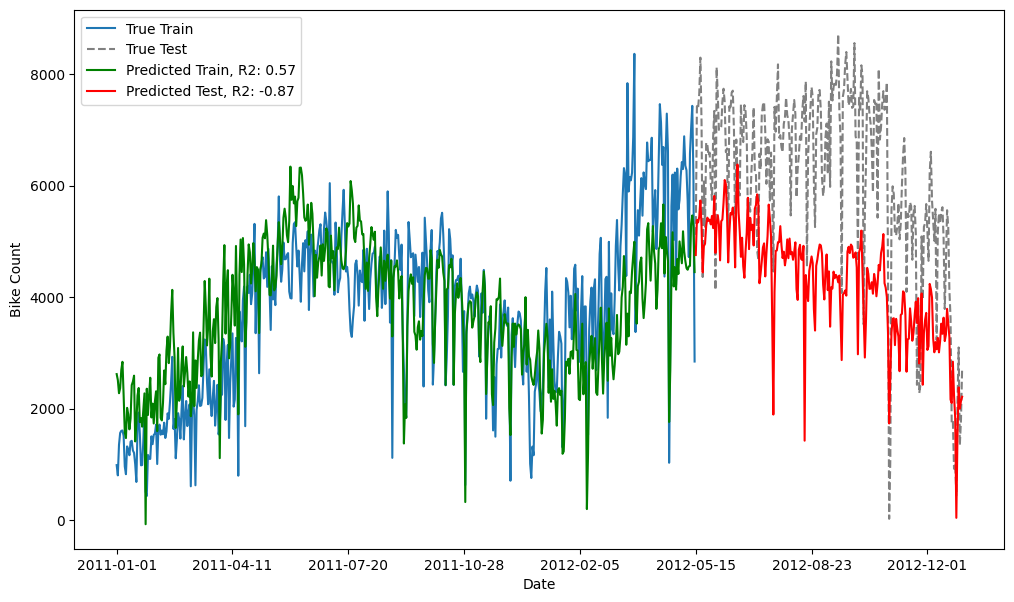

In [12]:
# Visualizing the performance of the model
def plot_predictions(model, X_train, X_test, y_train, y_test, y, dates=dates):
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  # Evaluate 
  r2_train = r2_score(y_train, y_pred_train)
  r2_test = r2_score(y_test, y_pred_test)

  plt.subplots(figsize=(12, 7))
  plt.plot(dates[:500], y[:500], label='True Train')
  plt.plot(dates[500:], y[500:], c='gray', ls='--', label='True Test')
  plt.plot(dates[:500], y_pred_train, c='green', label ='Predicted Train, R2: {:.2f}'.format(r2_train))
  plt.plot(dates[500:], y_pred_test, c='red', label ='Predicted Test, R2: {:.2f}'.format(r2_test))
  plt.xticks(dates[::100])
  plt.xlabel('Date')
  plt.ylabel('Bike Count')
  plt.legend()
  plt.show()

# TODO: plot predictions
plot_predictions(lin_reg, X_train, X_test, y_train, y_test, y, dates=dates)


C:\Users\Bruna\AppData\Local\Temp\ipykernel_14064\1419758483.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')


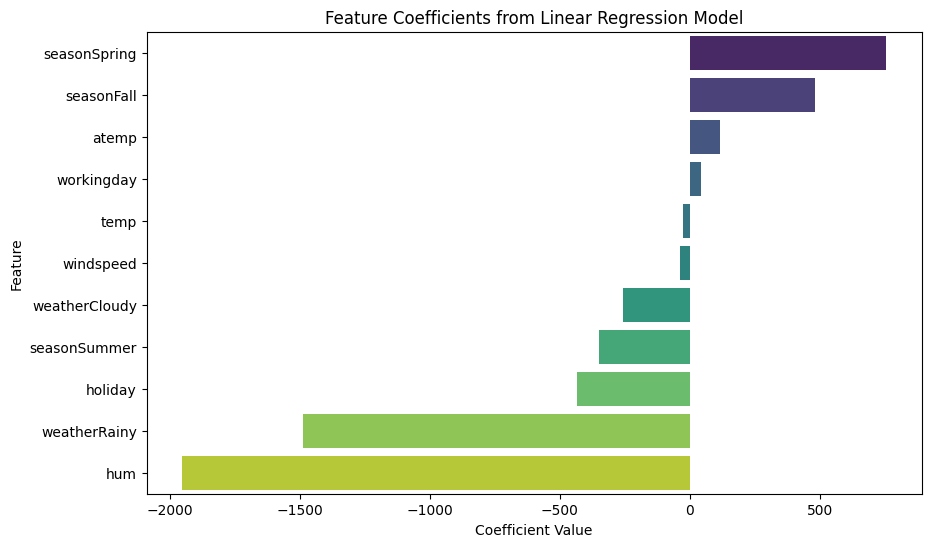

In [13]:
def plot_coefficients(model, feature_names):
  coefficients = model.model.coef_
  coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
  coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

  plt.figure(figsize=(10, 6))
  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
  plt.title('Feature Coefficients from Linear Regression Model')
  plt.xlabel('Coefficient Value')
  plt.ylabel('Feature')
  plt.show()

# Plot coefficients
plot_coefficients(lin_reg, X.columns)

C:\Users\Bruna\AppData\Local\Temp\ipykernel_14064\1318614936.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


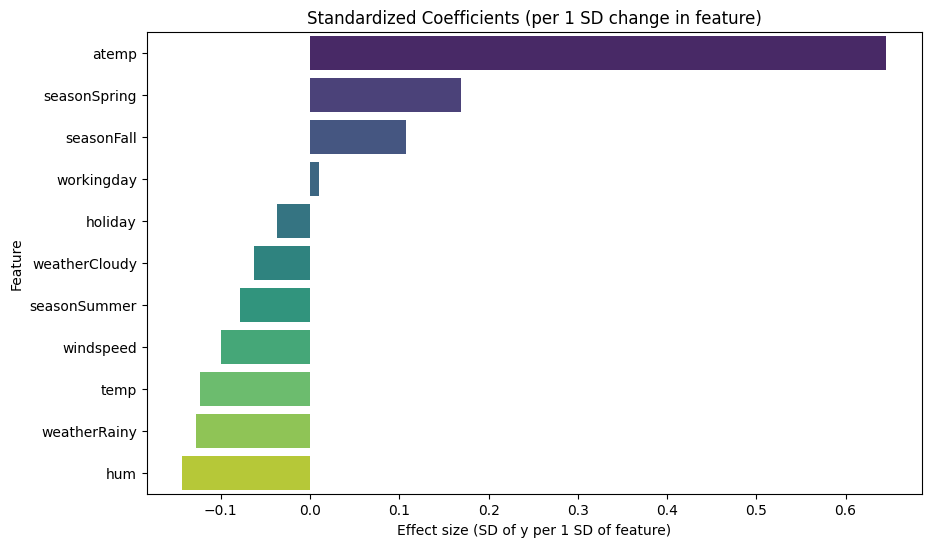

In [14]:
def plot_standardized_coefficients(model, X, y):
    coefs = model.get_coefficients()
    sigma_x = X.std()
    sigma_y = y.std()
    std_coefs = coefs * (sigma_x.values / sigma_y)

    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Std_Coefficient': std_coefs
    }).sort_values(by='Std_Coefficient', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Std_Coefficient',
        y='Feature',
        data=coef_df,
        palette='viridis'
    )
    plt.title('Standardized Coefficients (per 1 SD change in feature)')
    plt.xlabel('Effect size (SD of y per 1 SD of feature)')
    plt.ylabel('Feature')
    plt.show()

# usage:
plot_standardized_coefficients(lin_reg, X, y)

#### **Questions**:
- Is the model overfitting or underfitting?
- Which features *seem* important from the coefficients?

The model is underfitting.

## Improve model

The data is non-stationary and the baseline model misses systematic structure over time.

#### **Tasks**:
1. Make a change to the features to improve test performance.
2. Refit the model.
3. Recompute train/test R².
4. Re‑plot predictions.

In [16]:
# TODO: Bring modifications to improve performance

# Add a time index to capture global trend
time_index = np.arange(len(df))
df['time'] = time_index

# Drop column that seems more irrelevant
X, y =  df.drop(columns=['cnt', 'windspeed', 'workingday', 'holiday', 'atemp', 'seasonFall', 'seasonSpring']), df['cnt']

# Add a time index to capture global trend
time_index = np.arange(len(X))
X['time'] = time_index

# Re-split the data
X_train, X_test = X.iloc[:500], X.iloc[500:]
y_train, y_test = y[:500], y[500:]

# Fit again a linear regression    
lin_reg2 = LinearRegressionModel()
lin_reg2.fit(X_train, y_train)
# Compute R2 scores on train and test sets
r2_train = lin_reg2.compute_r2(X_train, y_train)
r2_test = lin_reg2.compute_r2(X_test, y_test)
# Compute coefficients
linreg_coefficients = lin_reg2.get_coefficients()

print(f'R2 Train: {r2_train:.2f}')
print(f'R2 Test: {r2_test:.2f}')

R2 Train: 0.75
R2 Test: 0.40


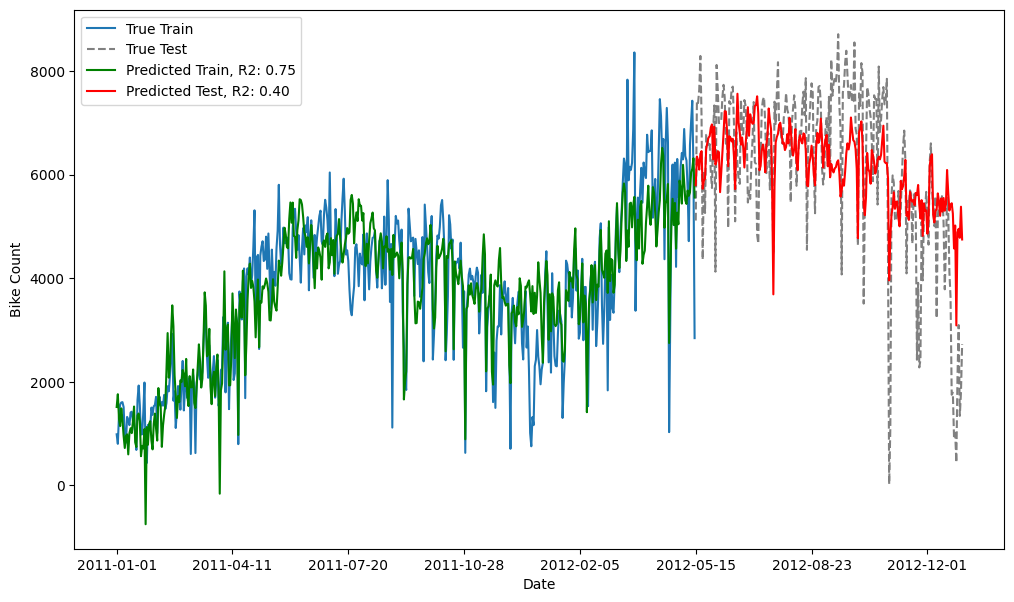

In [17]:
# TODO: plot predictions
plot_predictions(lin_reg2, X_train, X_test, y_train, y_test, y, dates=dates)

#### **Questions**:
Why did your modification help (or didn’t)?

Because I removed some features that were not particularily contributing to the fitting, as well as I added the temporal structure by adding a column corresponding to the time index.

## Model with confidence intervals

We now fit the same linear model using statsmodels to obtain standard errors and 95% confidence intervals (CI) for each coefficient.

#### **Tasks**:
1. Evaluate the model using `r2score`.
2. Visualize using `weight_plot(model, labels=...)` to display coefficients with their CIs.

In [18]:
# Helper class to wrap a scikit-learn API around statsmodels models

class SMWrapper:

  def __init__(self, sm_model_class, add_intercept=True, classification=False):
    self.sm_model_class = sm_model_class
    self.model = None
    self.add_intercept = add_intercept
    self.classification = classification

  def handle_intercept(self, X):
    if self.add_intercept:
      if isinstance(X, pd.DataFrame):
        _X = X.copy()
        _X['intercept'] = np.ones(X.shape[0])
      else:
        _X = np.hstack(X, np.ones(X.shape[0]))
    else:
      _X = X
    return _X

  def fit(self, X, y):
    _X = self.handle_intercept(X)
    self.model = self.sm_model_class(y, _X)
    self.results = self.model.fit()
    return self.results

  def predict(self, X):
    _X = self.handle_intercept(X)
    preds = self.model.predict(self.results.params, _X)
    if self.classification:
      if len(preds.shape) == 1:
        preds = (preds > 0.5).astype(int)
      else:
        preds = np.argmax(preds, axis=1)
    return preds


In [19]:
# Fit linear regression
model = SMWrapper(sm.OLS)
result = model.fit(X_train, y_train)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     241.3
Date:                Tue, 25 Nov 2025   Prob (F-statistic):          3.49e-143
Time:                        15:49:31   Log-Likelihood:                -4035.9
No. Observations:                 500   AIC:                             8086.
Df Residuals:                     493   BIC:                             8115.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
temp            133.4714      5.659     23.584      0.000     122.352     144.591
hum           -1095.9699    295.069     -3.714      0.000   -1675.717    -516.223
weatherCloudy  -284.1087     90.344     -3.145      0.002    -461.616    -106.601
weatherRainy  -1821.8552    213.583     -8.530      0.000   -2241.500   -1402.211
seasonSummer   -744.1747    118.662     -6.271      0.000    -977.320    -511.029
time              5.1931      0.246     21.132      0.000       4.710       5.676
intercept      1588.4818    175.585      9.047      0.000    1243.495    1933.469
==============================================================================
Omnibus:                       37.439   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.026
Skew:                          -0.425   Prob(JB):                     4.19e-18
Kurtosis:                       4.766   Cond. No.                     2.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
result.params

temp              133.471377
hum             -1095.969859
weatherCloudy    -284.108718
weatherRainy    -1821.855204
seasonSummer     -744.174730
time                5.193133
intercept        1588.481796
dtype: float64

In [21]:
coef_df = result.params.reset_index()
coef_df.columns = ["Feature", "Coefficient"]
coef_df.head()

,Feature,Coefficient
0,temp,133.471377
1,hum,-1095.969859
2,weatherCloudy,-284.108718
3,weatherRainy,-1821.855204
4,seasonSummer,-744.174730


In [22]:
# TODO: Evaluate
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
r2_train_value = r2_score(y_train, preds_train)
r2_test_value = r2_score(y_test, preds_test)
print(f'R2 Train: {r2_train_value:.2f}\nR2 Test: {r2_test_value:.2f}')

R2 Train: 0.75
R2 Test: 0.40


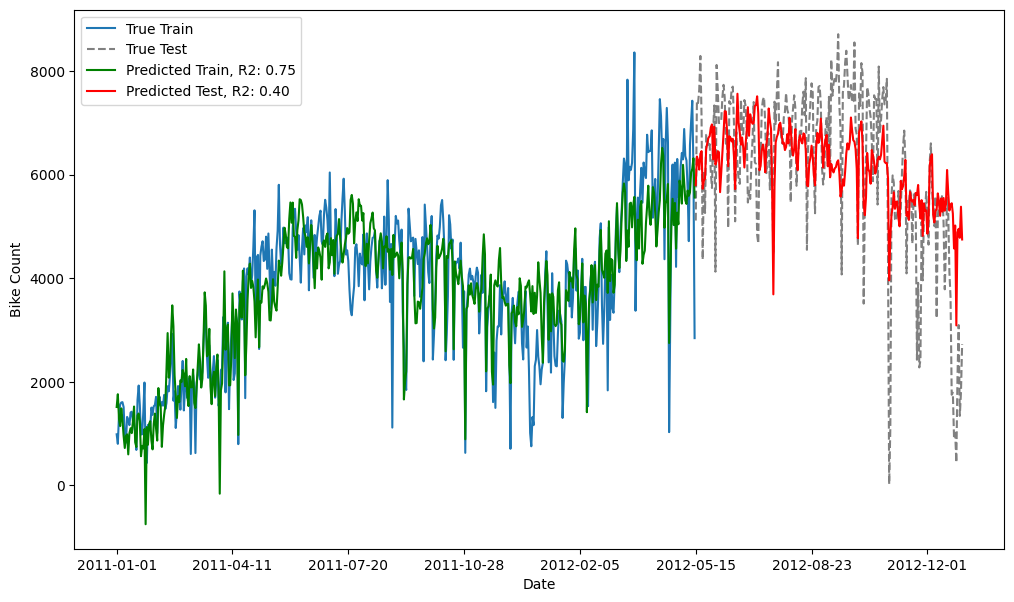

In [23]:
# TODO: plot predictions
plot_predictions(model, X_train, X_test, y_train, y_test, y, dates=dates)

In [24]:
result.conf_int()

,0,1
temp,122.351680,144.591075
hum,-1675.717194,-516.222524
weatherCloudy,-461.616423,-106.601013
weatherRainy,-2241.499511,-1402.210897
seasonSummer,-977.320260,-511.029200
time,4.710298,5.675969
intercept,1243.494511,1933.469082


In [25]:
len(X.columns)
len(coef_df)

7

In [26]:
def weight_plot(model, labels=None):
  result = model.results
  params = result.params
  if isinstance(params, pd.DataFrame):
    params = params.values
  ci = result.conf_int()
  fig, ax = plt.subplots(figsize=(8, 10))
  xerrs = np.abs(ci.T - np.vstack([params] * 2))
  plt.errorbar(params, -np.arange(len(params)), xerr=xerrs, fmt='o', capsize=5, c='k')
  if labels is not None:
    plt.yticks(-np.arange(len(params)), labels)
  elif isinstance(params, pd.DataFrame):
    plt.yticks(-np.arange(len(params)), params.index)
  ax.grid()
  plt.show()


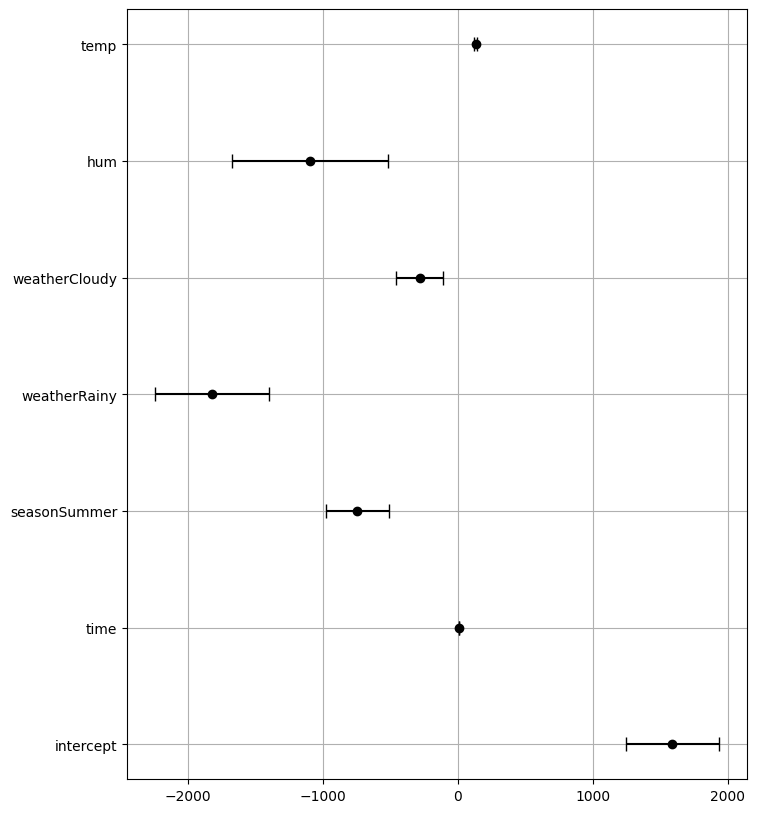

In [27]:
# TODO: plot with CI using weight plot
weight_plot(model, labels=X.columns.tolist() + ['intercept'])

#### **Questions:**
- Which coefficients are clearly non‑zero?
- Which ones are uncertain / overlap with 0?

## Model on normalized data

Normalization changes coefficient scales, which can affect both performance and interpretability.
We use `StandardScaler` to standardize features (zero mean, unit variance).

Redo the same analysis as above (with the improved model) but using the normalized features.

#### **Tasks**:
1. Train a baseline normalized linear model.
2. Fit the statsmodels version and re‑plot predictions and coefficient CIs.
3. Compare the plots to the non‑normalized case.

In [28]:
# Refit on normalized data
X, y = df.drop(columns=['cnt']), df['cnt']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)
X_train, X_test = X_scaled[:500], X_scaled[500:]
y_train, y_test = y[:500], y[500:]

In [29]:
model = SMWrapper(sm.OLS)
result = model.fit(X_train, y_train)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     155.0
Date:                Tue, 25 Nov 2025   Prob (F-statistic):          1.16e-157
Time:                        15:49:32   Log-Likelihood:                -3985.3
No. Observations:                 500   AIC:                             7997.
Df Residuals:                     487   BIC:                             8051.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
holiday         -90.1347     33.491     -2.691      0.007    -155.940     -24.329
workingday       26.4576     32.950      0.803      0.422     -38.284      91.199
temp            841.0689    427.421      1.968      0.050       1.252    1680.886
atemp            31.5350    418.303      0.075      0.940    -790.367     853.437
hum            -202.5316     41.550     -4.874      0.000    -284.171    -120.892
windspeed      -200.3798     35.674     -5.617      0.000    -270.474    -130.285
weatherCloudy  -137.9042     39.905     -3.456      0.001    -216.311     -59.498
weatherRainy   -275.5950     33.760     -8.163      0.000    -341.929    -209.261
seasonSpring    349.5471     45.212      7.731      0.000     260.712     438.382
seasonSummer    -14.6596     67.835     -0.216      0.829    -147.945     118.626
seasonFall       69.1168     45.129      1.532      0.126     -19.555     157.789
time           1112.5193     48.311     23.028      0.000    1017.596    1207.442
intercept      4496.8980     42.062    106.911      0.000    4414.252    4579.544
==============================================================================
Omnibus:                       45.240   Durbin-Watson:                   1.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.192
Skew:                          -0.433   Prob(JB):                     2.93e-27
Kurtosis:                       5.261   Cond. No.                         30.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# TODO: Evaluate
preds_test = model.predict(X_test)
preds_train = model.predict(X_train)
r2_score_test = r2_score(y_test, preds_test)
r2_score_train = r2_score(y_train, preds_train)

print(f'R2 Test: {r2_score_test:.2f}')
print(f'R2 Train: {r2_score_train:.2f}')

R2 Test: 0.45
R2 Train: 0.79


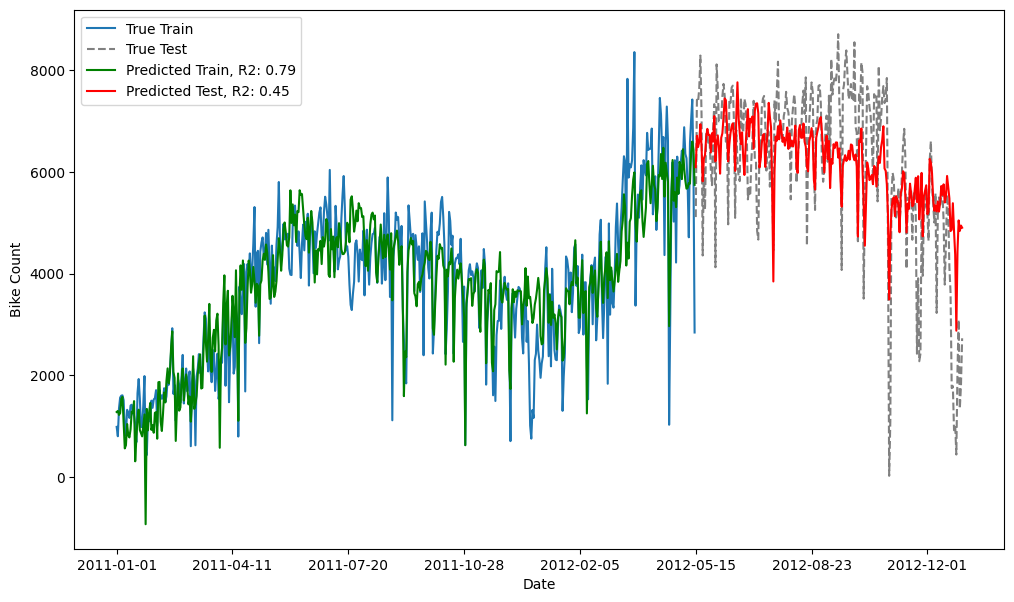

In [31]:
# TODO: plot predictions
plot_predictions(model, X_train, X_test, y_train, y_test, y, dates=dates)

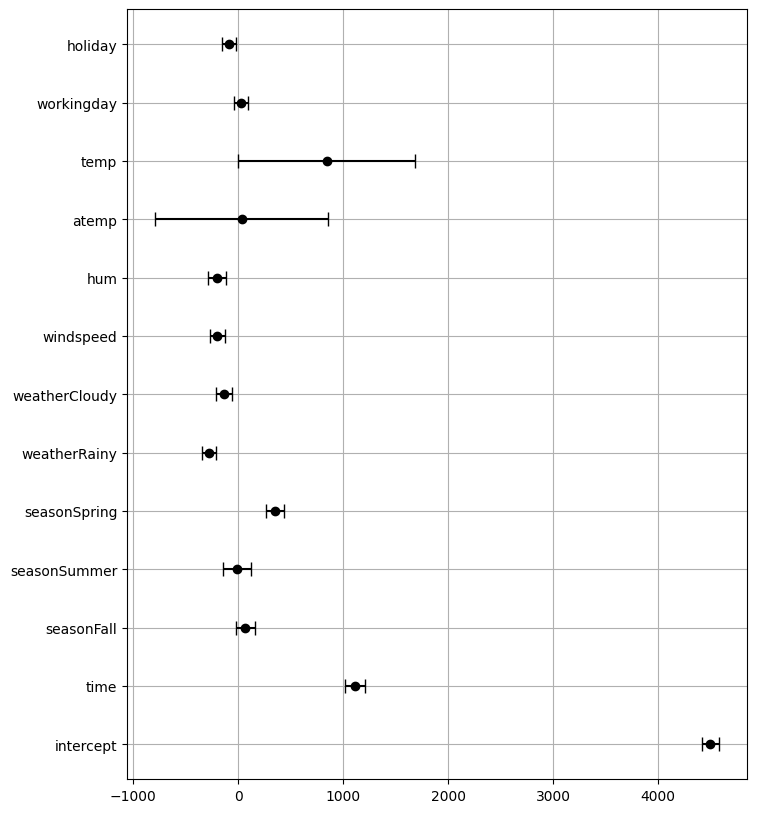

In [32]:
# TODO: plot CI
weight_plot(model, labels=X.columns.tolist() + ['intercept'])

#### **Questions:**
- Did performance change?
- How did normalization affect which variables look “important”?
- Which is easier to interpret, and why?

## Effects analysis

For linear models, each prediction can be decomposed into per‑feature effects:
\($\text{effect}^{(j)}_i = \hat{\beta}_j x^{(j)}_i$\).

#### **Tasks:**
- Implement `compute_effects` to get a matrix of contributions.
- Use `plot_effects` to visualize them.

In [33]:
# Back to non-normalized model
X_train, X_test = X.iloc[:500], X.iloc[500:]
y_train, y_test = y[:500], y[500:]

In [34]:
# TODO: complete

def compute_effects(model, X, normalize=False):
  if isinstance(model, SMWrapper):
    if model.add_intercept:
      params = np.array(model.results.params)[:-1]
      intercept = np.array(model.results.params)[-1]
    else:
      params = np.array(model.results.params)
      intercept = 0
  elif isinstance(model, sklearn.base.BaseEstimator):
    params = model.coef_
    intercept = model.intercept_

  # FILL HERE: complete code to compute effects


  if normalize:
    preds = model.predict(X)
    effects = (effects.T / (preds - intercept)).T

  return effects

In [35]:
# TODO: compute the effects


In [36]:
def plot_effects(effects):
  fig, ax = plt.subplots(figsize=(8, 10))
  sns.boxplot(effects, orient='h', ax=ax)

In [37]:
# TODO: plot the effects


## Lasso model

Now we add L1 regularization to encourage sparsity (fewer non‑zero coefficients).

#### **Tasks:**
1. Fit and evaluate linear regression with L1 regularization.
2. Compute and plot effects.

In [38]:
# TODO: fit and evaluate linear regression with L1 regularization


In [39]:
# TODO: compute and plot effects


#### **Questions:**
- How do the results compare to the above linear regression model without regularization?

## Bonus:

1) Explain the predictions for the downward peaks observed in the test set (and correctly identified by the model). Can you justify why the model predicts low rentals these days?

2) Can you explain why some of the top peaks in the test data are not identified by the model? What is the rationale in the predictions these days?

3) Can you prune some of the input variables out of your model? If yes, which ones, and can you train a model without them and check its performance?

4) Try to train more complex models. Does the performance increase? Can you explain their predictions?

5) In the linear regression case, think about some business logic for an applications that gives predictions with explanations, and how it interfaces with your model.

# Part 2: Classification (Breast cancer)

We now predict whether a tumor is malignant or benign from cell‑nuclei features.

In [40]:
# Load data
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data=data.data, columns=data.feature_names)
y = data.target

In [41]:
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [42]:
# Preprocessing (these columns almost collinear)
X = X.drop(columns=['worst perimeter', 'worst area', 'mean perimeter', 'mean area'])

## Logistic regression

Train a baseline `LogisticRegression` classifier.

#### **Tasks:**
1. Fit the classifier.
2. Report accuracy on train and test.
3. Plot the confusion matrix for train and test samples (using `ConfusionMatrixDisplay`, `confusion_matrix`)

In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
# TODO: train a logistic regression model and evaluate it


In [45]:
# TODO: plot confusion matrix


#### **Questions:**
- What's the rate of false negatives and false positives? Are there any similarities in the samples that are misclassified?

## Obtaining confidence intervals with bootstrapping

We approximate uncertainty in logistic regression coefficients using bootstrap resampling.
Bootstrapping is a procedure for estimating the distribution of an estimator by resampling the data or the model estimated from the data.

#### **Tasks:**
1. Randomly sample the data ($p=0.7$) and train a model on the sampled data.
2. Repeat for 10 models (collecting the models) to get a distribution over the weights.
3. Plot boxplot of means and 95% intervals.

In [46]:
# TODO: train 10 models with bootstrapping (p=0.7) and visualize the
# distribution of obtained weights
boot_p = 0.7
boot_n = int(boot_p * X_train.shape[0])

models = []
for _ in range(10):
  # TODO: FILL HERE


SyntaxError: incomplete input (427769927.py, line 8)

In [ ]:
def plot_all_weights(models, labels=None):
  fig, ax = plt.subplots(figsize=(8, 10))
  params = np.zeros((len(models), models[0].coef_.shape[1] + 1))
  for i, mod in enumerate(models):
    params[i] = np.append(mod.coef_, mod.intercept_)
  params_data = pd.DataFrame(data=params, columns=labels)
  sns.boxplot(params_data, orient='h')
  plt.show()

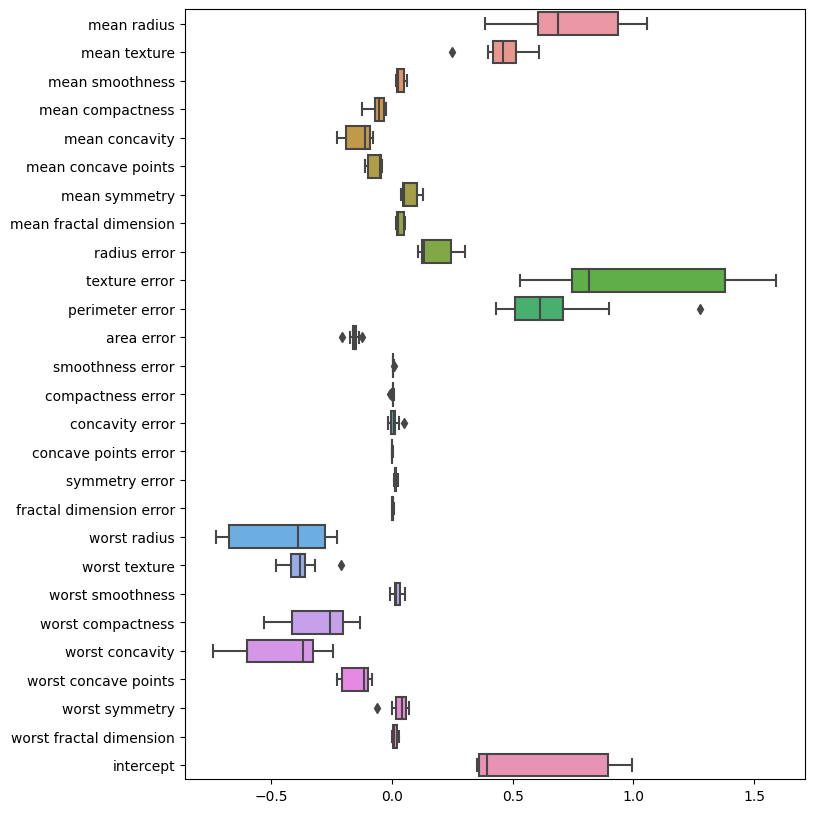

In [ ]:
plot_all_weights(models, labels=X_train.columns.tolist() + ['intercept'])

#### **Questions:**
- Which coefficients are consistently non‑zero?
- Which ones vary a lot across bootstraps?

## Visualization of effects

Like in Part 1, we can decompose each prediction into per‑feature contributions.

Visualize effects for the logistic regression model.

#### **Tasks:**
1. Use your `compute_effects` and `plot_effects` functions from Part 1.
2. Plot effects for test points with normalization.

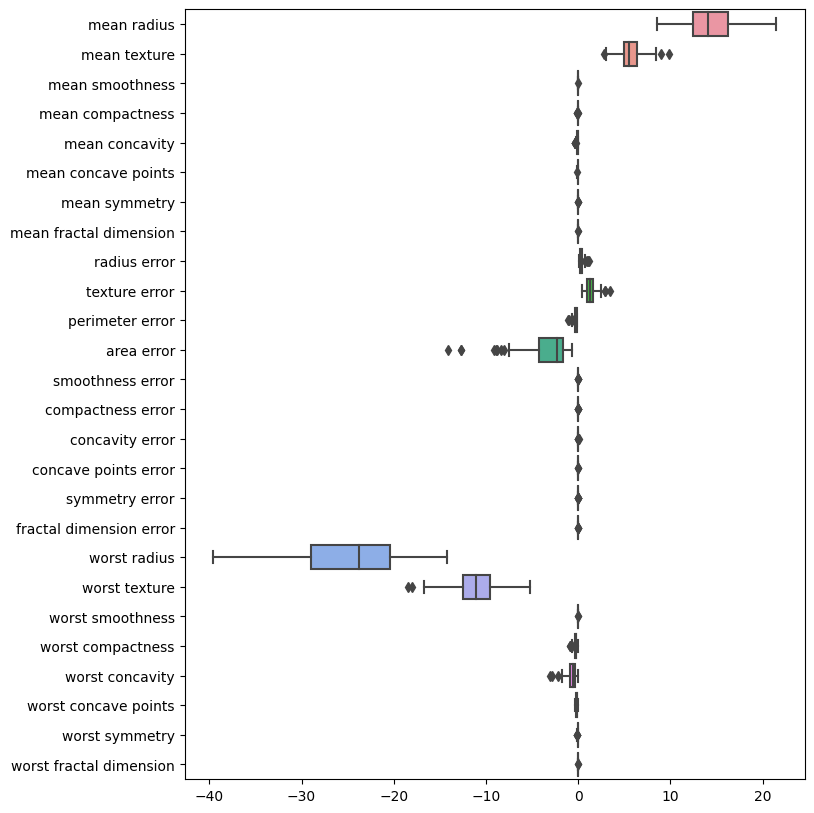

In [ ]:
# TODO: compute and plot effects without normalization


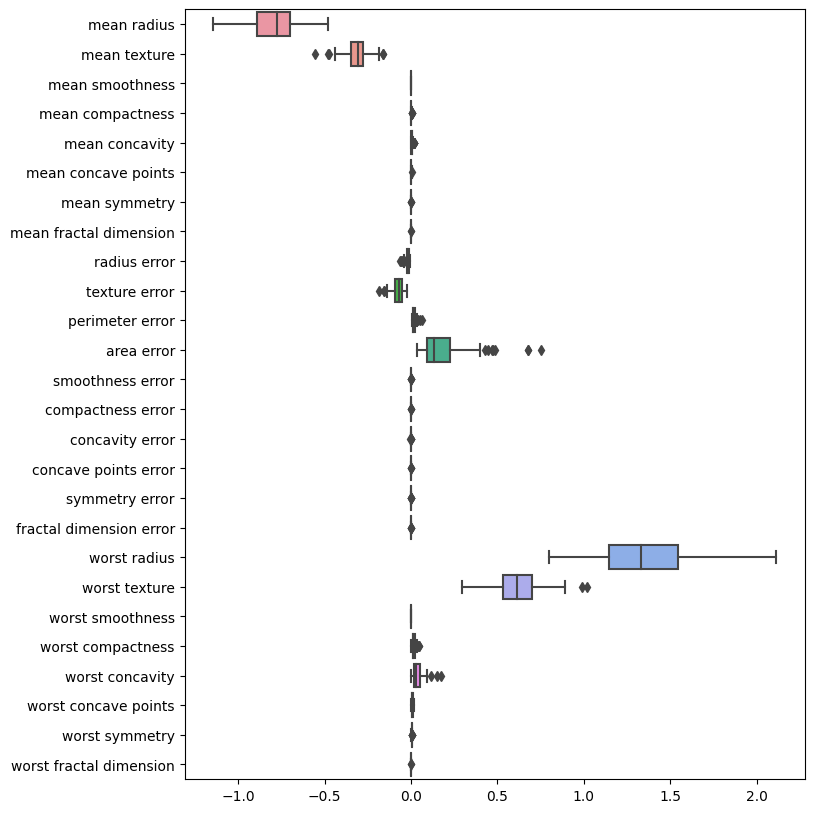

In [ ]:
# TODO: compute and plot effects with normalization


## Now with normalization

Feature scales differ a lot in this dataset, so normalization can strongly affect both coefficients and regularization.

Perform the same analysis on a model trained on normalized data.

#### **Tasks:**
1. Fit logistic regression.
2. Evaluate accuracy.
3. Run bootstrapping for CIs.
4. Visualize effects.
5. Compare to the non‑normalized case.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# TODO: bootstrap for CI on normalized data


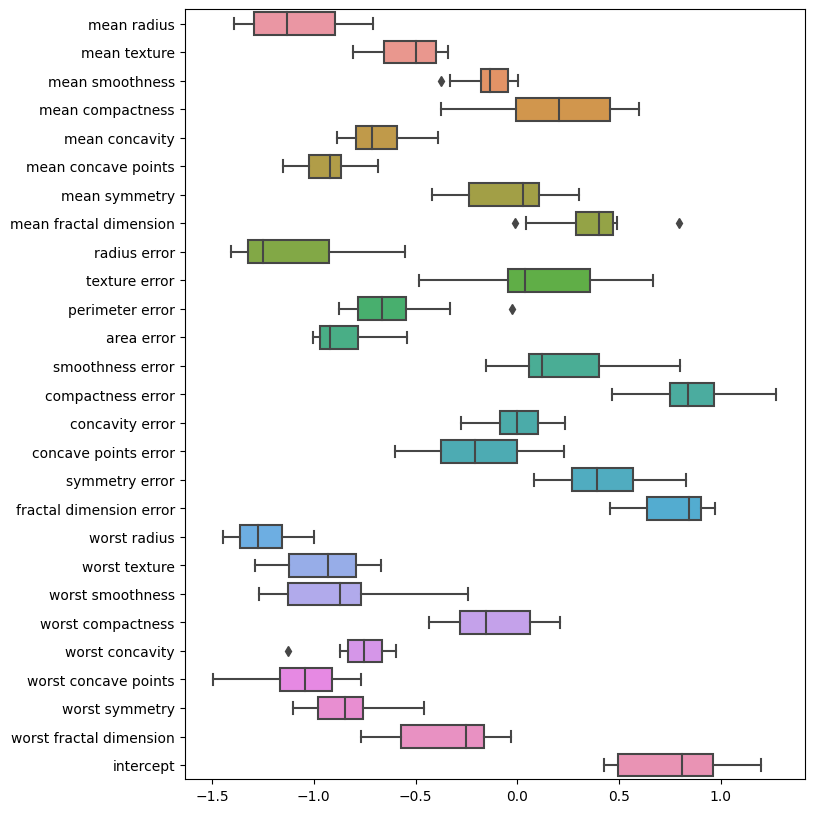

In [ ]:
# TODO: plot the CI


In [ ]:
# TODO: fit and evaluate the logistic regression model on normalized data


Accuracy on test set: 0.93 (on train set: 0.99)


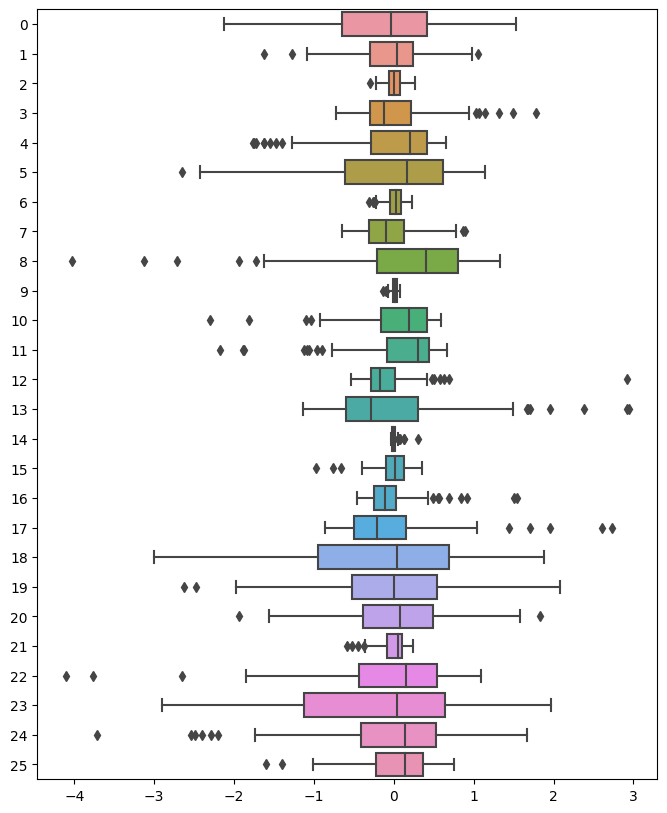

In [ ]:
# TODO: compute and plot effects


## Lasso model

Now we add L1 regularization to encourage sparsity (fewer non‑zero coefficients).

#### **Tasks:**
1. Fit and evalute logistic regression with L1 regularization.
2. Plot confusion matrices.
3. Compute and plot effects.

In [ ]:
# TODO: fit and evaluate logistic regression with L1 regularization


Accuracy on test set: 0.96 (on train set: 0.99)


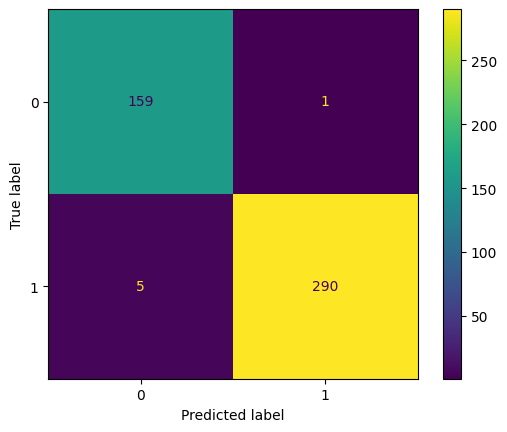

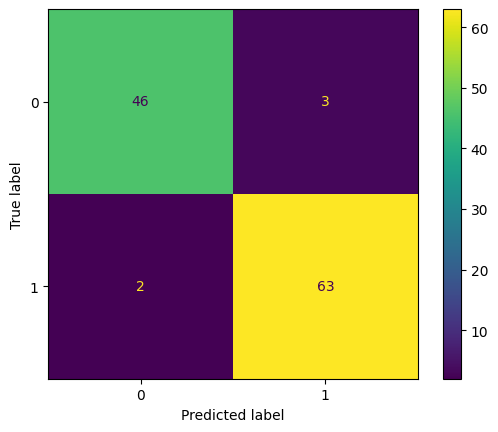

In [ ]:
# TODO: plot confusion matrices


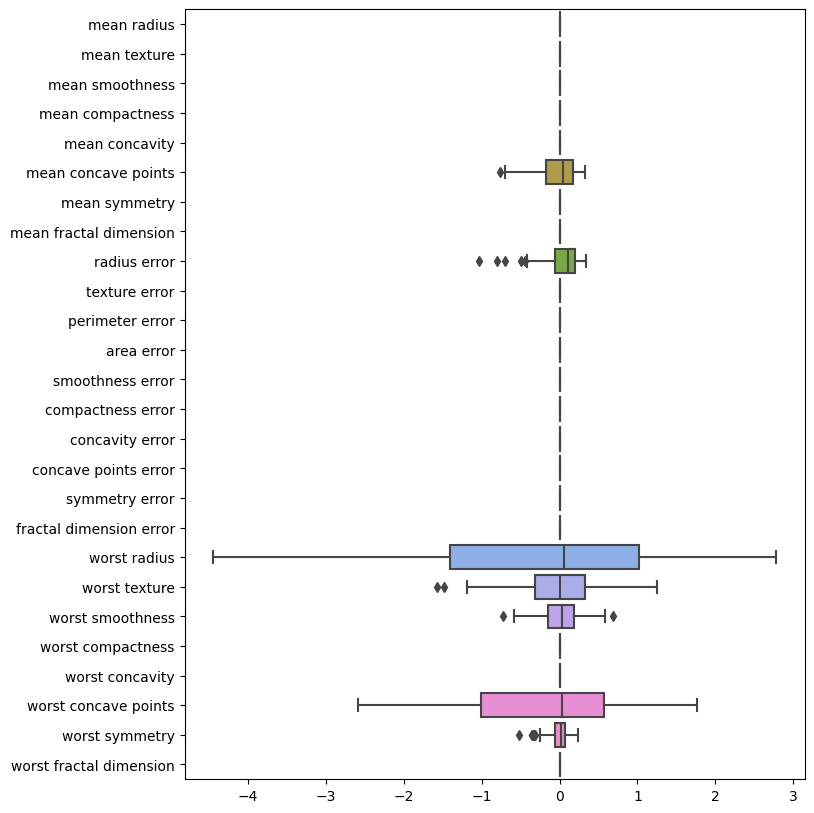

In [ ]:
# TODO: compute and plot effects


#### **Questions:**
- How do the results compare to the above logistic regression model without regularization?
- Do the results seem reasonable (e.g., do the non-zero coefficients seem like the most important features?)?

## Going further

1. Pick a few examples recognized as malignant cases and explain the classifier's decision. How would you explain the diagnostic to a patient?

2) Try to get a classifier using as few features as possible while keeping similar performance. The original paper did it with 3 features only (in 1992): https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf?sequence=1

3) Compare the use of L2 and L1 regularization on the interpretation of obtained classifiers.